In [1]:
from IPython.display import clear_output

!wget -O event_log.xes https://www.dropbox.com/scl/fi/paeuut93tkmropem01eu8/BPIC15_1.xes?rlkey=t9lz1uda4natgto91gqd7g4zf&dl=1

clear_output()
print("Log loaded.")

Log loaded.


In [2]:
!pip install mpvis
!pip install pm4py

clear_output()
print("Packages installed.")

Packages installed.


In [3]:
import mpvis
from mpvis import mddrt
from mpvis import mpdfg
import pm4py
import pandas as pd
from datetime import datetime
from IPython.display import SVG, display
clear_output()

In [4]:
event_log = pm4py.read_xes('event_log.xes')

log_format = {'case:concept:name': 'case:concept:name',
              'concept:name': 'concept:name',
              'time:timestamp': 'time:timestamp',
              'start_timestamp': '',
              'org:resource': 'org:resource',
              'cost:total': ''}

event_log = mpvis.log_formatter(event_log.copy(), log_format)

parsing log, completed traces ::   0%|          | 0/1199 [00:00<?, ?it/s]

In [5]:
print("Case count: " + str(len(set(event_log['case:concept:name']))))
print("Variant count: " + str(len(pm4py.stats.get_variants(event_log.copy()))))
print("Event count: " + str(len(event_log['case:concept:name'])))
print("Activity count: " + str(len(set(event_log['concept:name']))))

Case count: 1199
Variant count: 1170
Event count: 52217
Activity count: 398


In [6]:
mpdfg_discovery_start = datetime.now()

dfg, start_activities, end_activities = mpdfg.discover_multi_perspective_dfg(event_log.copy())

mpdfg_discovery_end = datetime.now()

print("MP-DFG discovery time: " + str((mpdfg_discovery_end - mpdfg_discovery_start).total_seconds()) + " seconds.")

MP-DFG discovery time: 23.910564 seconds.


In [7]:
mddrt_discovery_start = datetime.now()

drt = mddrt.discover_multi_dimensional_drt(event_log.copy())

mddrt_discovery_end = datetime.now()

print("MD-DRT discovery time: " + str((mddrt_discovery_end - mddrt_discovery_start).total_seconds()) + " seconds.")

Calculating log mandatory activities: 


100%|██████████| 1199/1199 [00:08<00:00, 142.92it/s]


Calculating log metrics: 


100%|██████████| 1199/1199 [00:08<00:00, 134.97it/s]


Building Tree Cases:


100%|██████████| 1199/1199 [00:31<00:00, 38.65it/s]


Building Tree Graph:


100%|██████████| 1199/1199 [00:03<00:00, 320.86it/s]

MD-DRT discovery time: 52.242063 seconds.


In [8]:
mddrt_visualization_start = datetime.now()

mddrt.view_multi_dimensional_drt(drt)

mddrt_visualization_end = datetime.now()

print("MD-DRT visualization time: " + str((mddrt_visualization_end - mddrt_visualization_start).total_seconds()) + " seconds.")

Output hidden; open in https://colab.research.google.com to view.

In [20]:
print("MP-DFG discovery time: " + str((mpdfg_discovery_end - mpdfg_discovery_start).total_seconds()) + " seconds.")
print("MD-DRT discovery time: " + str((mddrt_discovery_end - mddrt_discovery_start).total_seconds()) + " seconds.")
print("MD-DRT visualization time: " + str((mddrt_visualization_end - mddrt_visualization_start).total_seconds()) + " seconds.")

MP-DFG discovery time: 23.910564 seconds.
MD-DRT discovery time: 52.242063 seconds.
MD-DRT visualization time: 4283.46603 seconds.


In [10]:
# A copy of the original log is used to allow comparing the processed and original logs
processed_log = event_log.copy()

In [11]:
# The original log contains several cases that are not flagged as complete (i.e., the requestComplete attribute is False)
# Only cases where the requestComplete attribute is True will be considered
processed_log = pm4py.filter_event_attribute_values(processed_log, 'case:requestComplete', ['TRUE'])

print("Case count before: " + str(len(set(event_log['case:concept:name']))))
print("Case count after: " + str(len(set(processed_log['case:concept:name']))))

Case count before: 1199
Case count after: 948


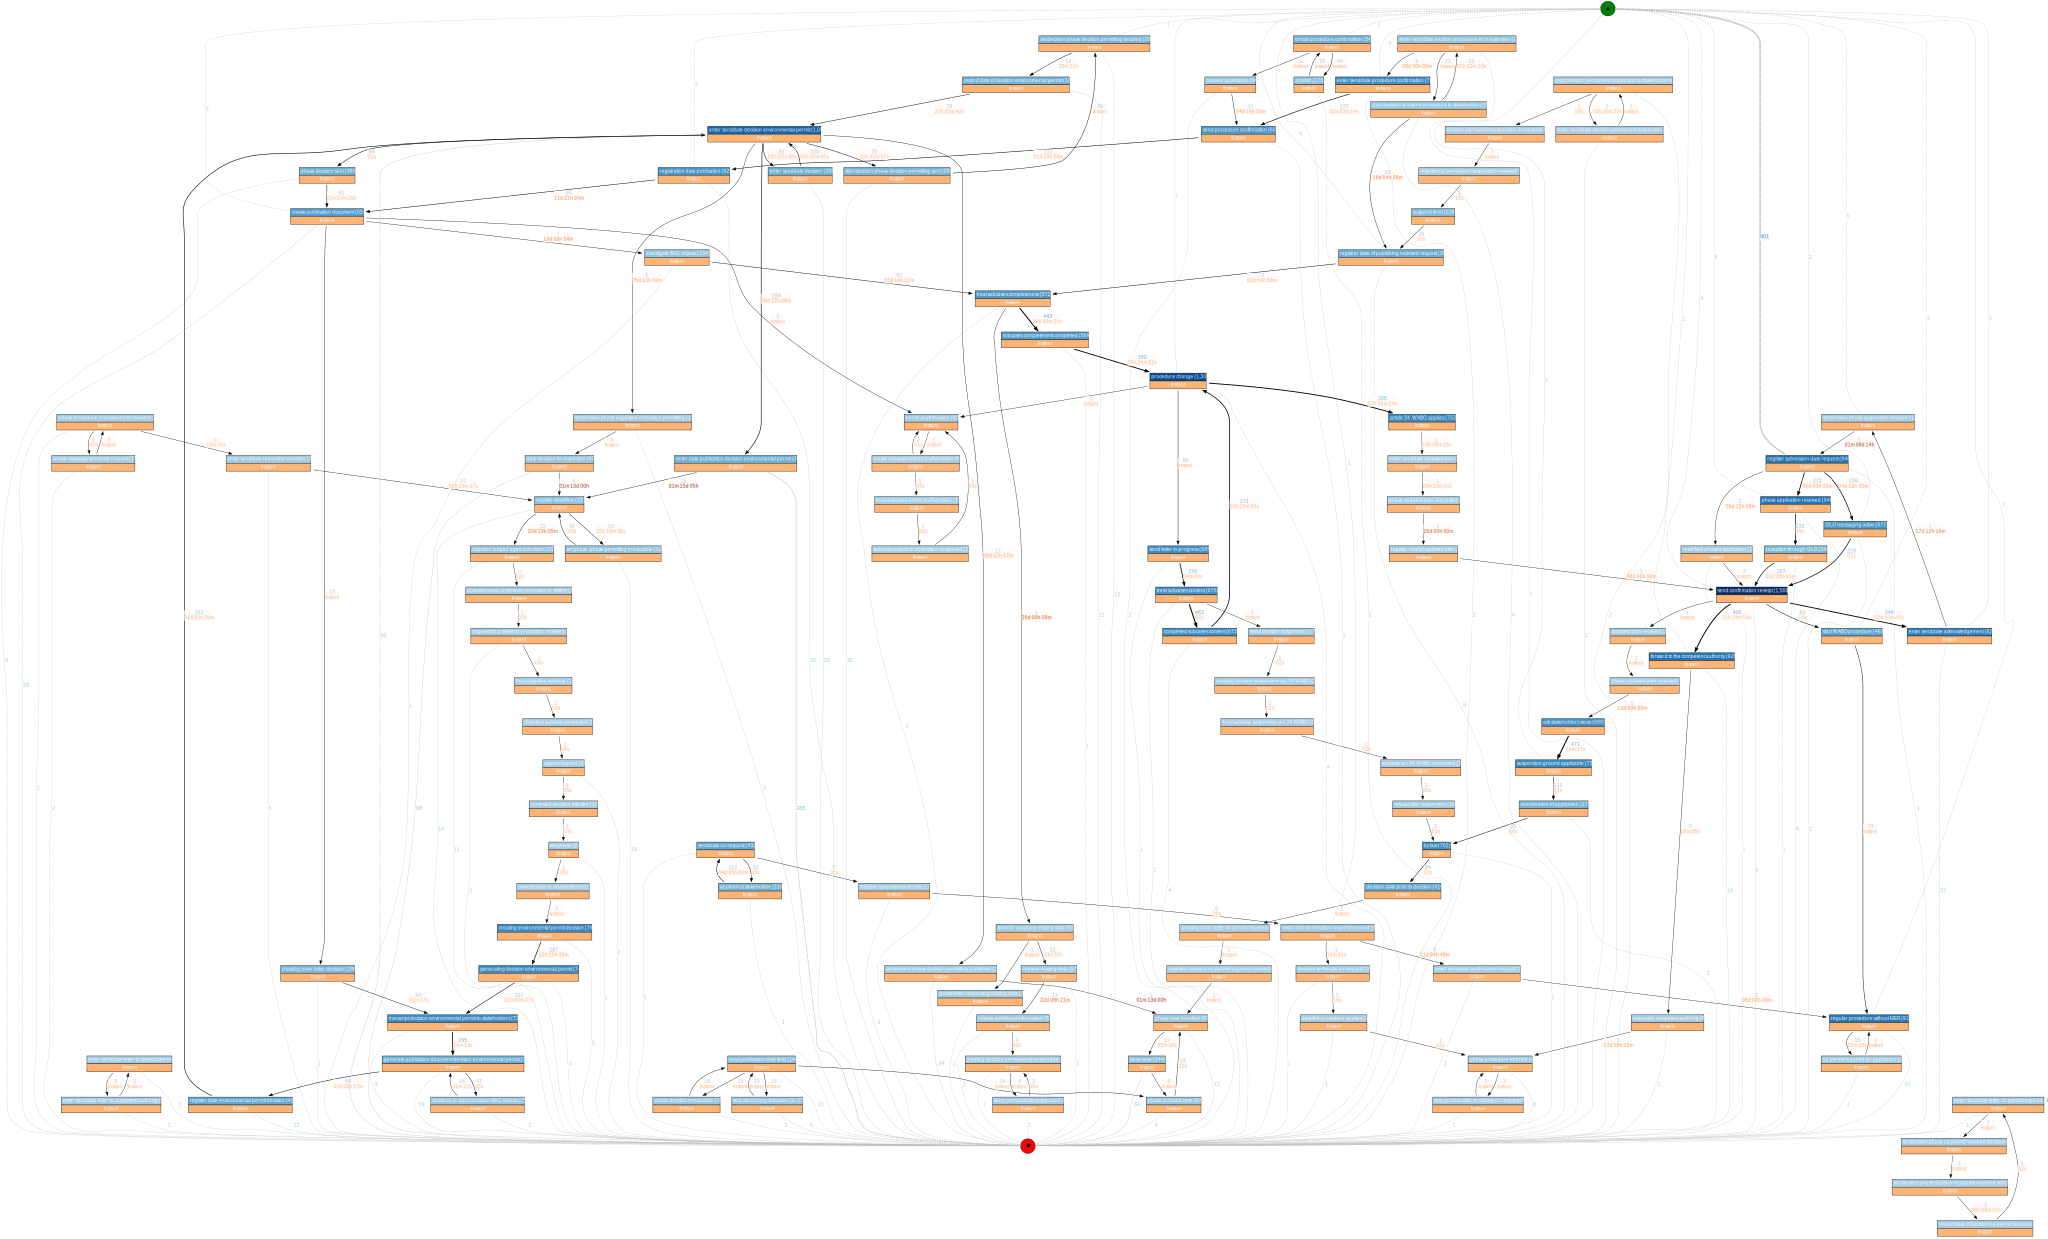

In [12]:
# Instead of using the default activity column, which contains codes instead of activity names, the column activityNameEN is used
dfg, start_activities, end_activities = mpdfg.discover_multi_perspective_dfg(processed_log.copy(), activity_key = 'activityNameEN')

# Due to the high complexity of the process, only the most common activities and paths are included in the visualization
filtered_dfg = mpdfg.filter_multi_perspective_dfg_activities(0, dfg, start_activities, end_activities)
filtered_dfg = mpdfg.filter_multi_perspective_dfg_paths(0, filtered_dfg, start_activities, end_activities)

mpdfg.save_vis_multi_perspective_dfg(filtered_dfg, start_activities, end_activities, file_name = 'dfg_processed_log_0_0', format = 'svg', visualize_cost = False)
display(SVG(filename = 'dfg_processed_log_0_0.svg'))

In [13]:
# Instead of using the default activity column, which contains codes instead of activity names, the column activityNameEN is used
drt = mddrt.discover_multi_dimensional_drt(processed_log.copy(), activity_key = 'activityNameEN')

# Due to the high complexity of the process, only the first 25 events of every case are considered
pruned_drt = mddrt.prune_tree_to_depth(drt, 25)

mddrt.save_vis_multi_dimensional_drt(pruned_drt, file_path = 'drt_processed_log_25_depth', visualize_cost = False)
display(SVG(filename = 'drt_processed_log_25_depth.svg'))

Output hidden; open in https://colab.research.google.com to view.

In [14]:
# An alternative to visualizing activity names is to group them based on their codes, as every code belongs to a different subprocess of the event log
processed_log['concept:name'] = processed_log['concept:name'].str.split('_').str[1]

print("Activity count before: " + str(len(set(event_log['concept:name']))))
print("Activity count after: " + str(len(set(processed_log['concept:name']))))

Activity count before: 398
Activity count after: 16


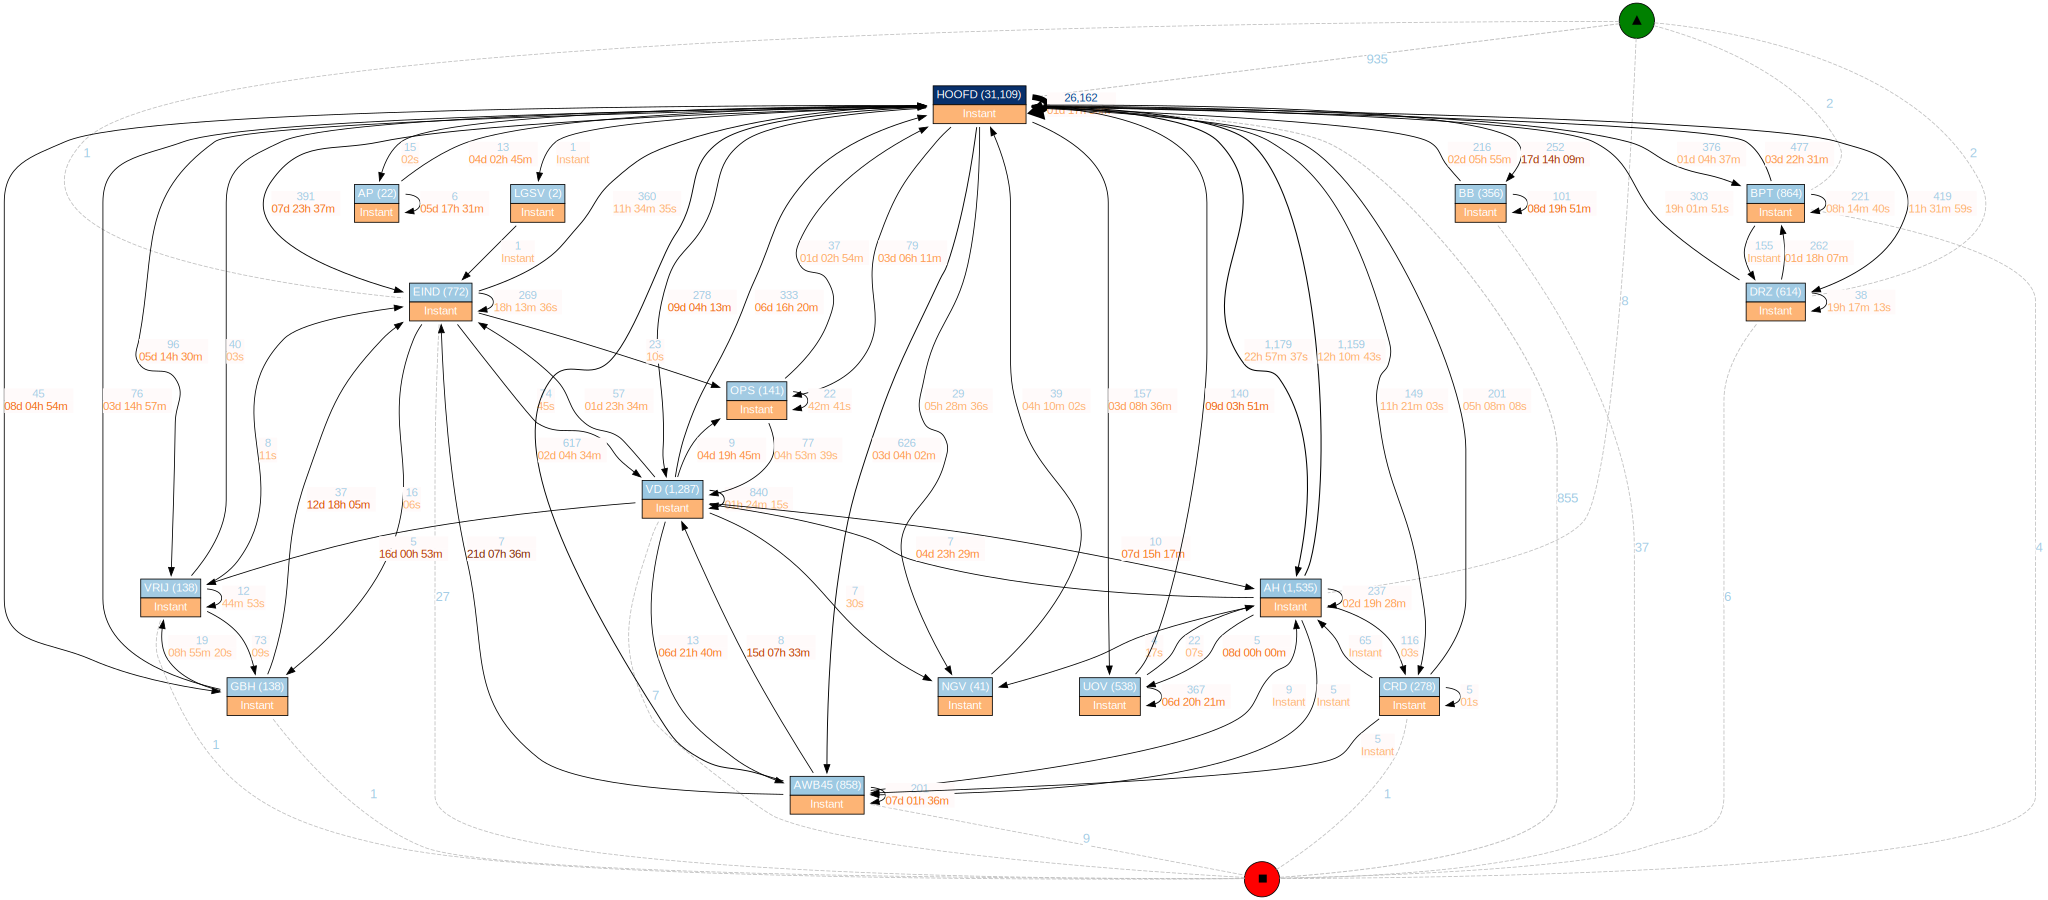

In [15]:
dfg, start_activities, end_activities = mpdfg.discover_multi_perspective_dfg(processed_log.copy())

# Due to the high complexity of the process, only the most common paths are included in the visualization
filtered_dfg = mpdfg.filter_multi_perspective_dfg_paths(50, dfg, start_activities, end_activities)

mpdfg.save_vis_multi_perspective_dfg(filtered_dfg, start_activities, end_activities, file_name = 'dfg_subprocesses_100_50', format = 'svg', visualize_cost = False)
display(SVG(filename = 'dfg_subprocesses_100_50.svg'))

In [16]:
# By activating the 'group_activities' flag, linear paths are grouped
drt = mddrt.discover_multi_dimensional_drt(processed_log.copy(), group_activities = True, show_names = True)
mddrt.save_vis_multi_dimensional_drt(drt, file_path = 'drt_subprocesses_autogroup', visualize_cost = False)
display(SVG(filename = 'drt_subprocesses_autogroup.svg'))

Output hidden; open in https://colab.research.google.com to view.

In [17]:
# Similarly, only one subprocess can be considered at a time to reduce the complexity of the visualization
# Only events that are related to the main process are retained
processed_log = pm4py.filter_event_attribute_values(processed_log, 'concept:name', ['HOOFD'], level = 'event')

print("Activity count before: " + str(len(set(event_log['activityNameEN']))))
print("Activity count after: " + str(len(set(processed_log['activityNameEN']))))

Activity count before: 289
Activity count after: 110


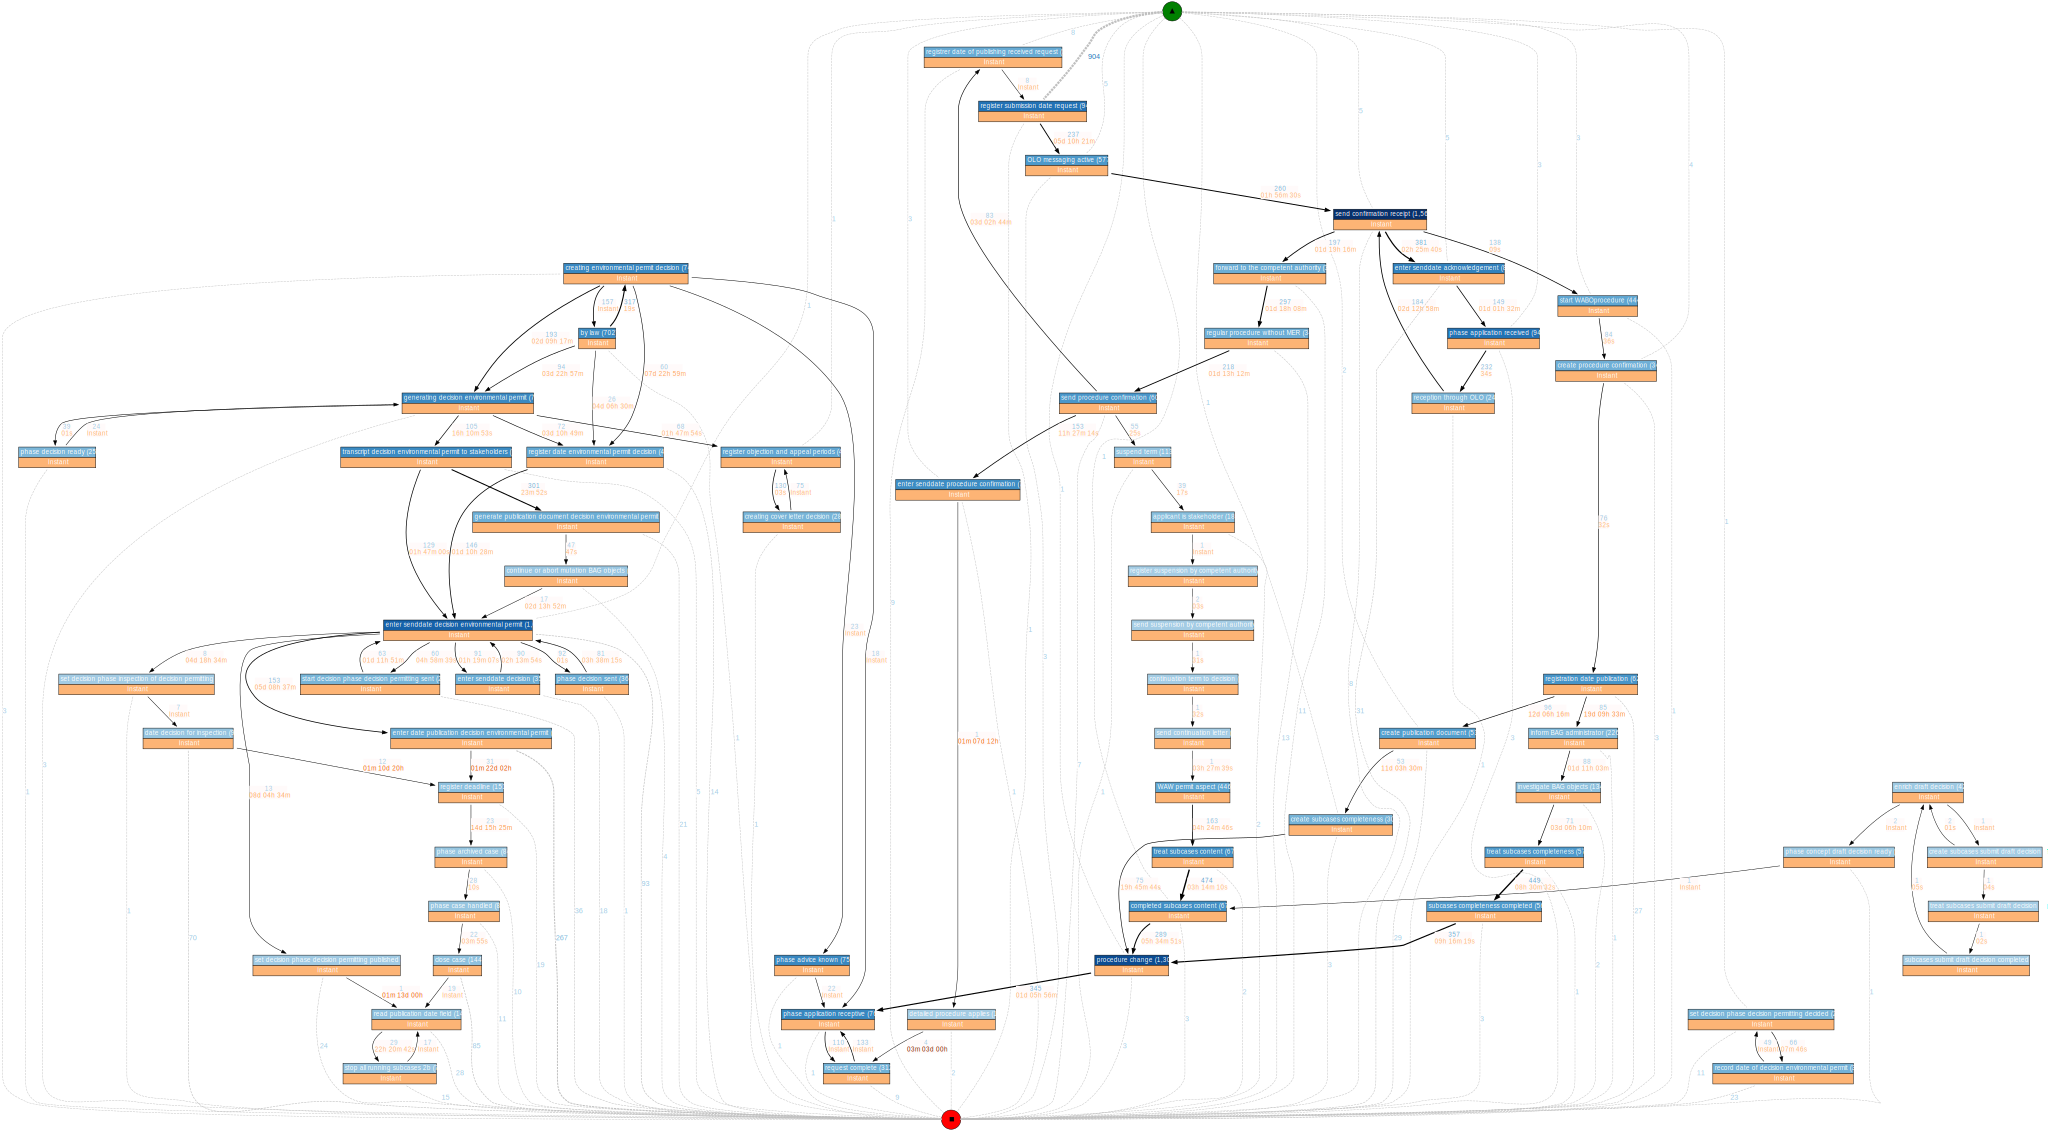

In [18]:
# Instead of using the default activity column, which contains codes instead of activity names, the column activityNameEN is used
dfg, start_activities, end_activities = mpdfg.discover_multi_perspective_dfg(processed_log.copy(), activity_key = 'activityNameEN')

# Due to the high complexity of the process, only the most common activities and paths are included in the visualization
filtered_dfg = mpdfg.filter_multi_perspective_dfg_activities(0, dfg, start_activities, end_activities)
filtered_dfg = mpdfg.filter_multi_perspective_dfg_paths(0, filtered_dfg, start_activities, end_activities)

mpdfg.save_vis_multi_perspective_dfg(filtered_dfg, start_activities, end_activities, file_name = 'dfg_main_process_0_0', format = 'svg', visualize_cost = False)
display(SVG(filename = 'dfg_main_process_0_0.svg'))

In [19]:
# Instead of using the default activity column, which contains codes instead of activity names, the column activityNameEN is used
drt = mddrt.discover_multi_dimensional_drt(processed_log.copy(), activity_key = 'activityNameEN')

# Due to the high complexity of the process, only the first 20 events of every case are considered
pruned_drt = mddrt.prune_tree_to_depth(drt, 20)

mddrt.save_vis_multi_dimensional_drt(pruned_drt, file_path = 'drt_main_process_20_depth', visualize_cost = False)
display(SVG(filename = 'drt_main_process_20_depth.svg'))

Output hidden; open in https://colab.research.google.com to view.